## Atari Games

**Atari 2600** is a video game console which provides several popular games such as pong, space invaders, pacman, break out, centipede and many more. Gymnasium includes [ALE-py](https://pypi.org/project/ale-py/), the **Arcade Learning Environment (ALE)** which is a simple framework that allows researchers to develop AI agents for Atari 2600 games. It is built on top of the **Stella emulator** and separates the details of emulation from agent design. The main Gymnasium page provides a list of all the [Atari environments](https://gymnasium.farama.org/environments/atari/).

The objective of this notebook is to **train an agent to play a game of the Atari console** using the DQN algorithm **learning from raw pixel data**, like in the famous paper [V. Mnih, et al. **"Playing Atari with Deep Reinforcement Learning"**, NIPS 2013](https://arxiv.org/abs/1312.5602):

<img src="./atari.png" width="600">

In particular, we can consider **the classic [Pong](https://gymnasium.farama.org/environments/atari/pong/) game**. The game is played like tennis. Using a controller, each player hits the ball by moving vertically the paddles on the game field. A player scores one point when the opponent misses a hit. The first player who scores 21 points wins the game.

- The action space is discrete and deterministic with 6 actions (not all meaningful for Pong): 0 (noop), 1 (fire), 2 (right) and 3 (left), 4 (right fire), 5 (left fire)

- The observation space is the screen image (210x160x3).  

The state space is really high-dimensional and to use it you need to modify the neural network architecture adding some convolutional layer in order to extract features from the image.

1 - Define a variable with the name of the Atari game you want to solve (e.g. Pong) and create an instance of the environment.

In [28]:
# YOUR CODE HERE

# Import Gymnasium and define a variable env_name with the name of the environment to be used 
# ('ALE/Pong-v5') in the rest of the notebook, and create an instance with "render_mode" set to 
# "rgb_array". Set also the parameter "frameskip" to 1. Later, we will see that we want to control
# the number of frames to skip ad a parameter of our code.


import gymnasium as gym

env_name = 'ALE/Pong-v5'

env = gym.make(env_name, render_mode="rgb_array", frameskip=1)

2 - Create a function to show the game in action by rendering the environment and selecting actions at random or using a policy.

In [29]:
# YOUR CODE HERE

# Use a function already created for other environments.

import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from itertools import count

def show_policy(env, agent, n_episodes=1, max_steps=500):
    for episode in count():
        
        action_size = env.action_space.n

        state = env.reset()[0]

        for step in count():

            if(agent is None):
                action = np.random.randint(action_size)
            else:
                action = greedy(agent, state)

            state, reward, is_terminal, is_truncated, info = env.step(action)
            done = is_terminal or is_truncated
            
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            
            if done or step > max_steps:
                break

        if episode >= n_episodes-1:
                break

3 - Use the previous function in order to see one episode of the game with a random policy.

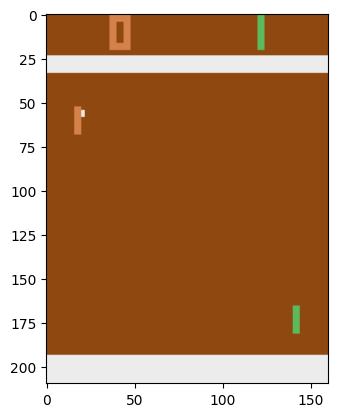

In [30]:
# YOUR CODE HERE

# Just call the "show_policy" function defined above passing the environment, None as agent and 
# the number of episodes you want to visualize

show_policy(env, None, n_episodes=1, max_steps=500)

4 - We would like to use as state the raw pixels data. However, **directly feeding the raw game screen image is not efficient**, since it will be **computationally expensive**. So we need to pre-process the state and the environment output to reduce the dimensionality of the problem. Moreover the Atari environments have some game specific issues, which are not relevant for the learning process, that we need to manage. In order to do that, you can use the **wrapper function**, which is a convenient way to modify an existing environment without having to alter the underlying code directly. Using wrappers will allow you to avoid a lot of boilerplate code and make your environment more modular.  Here a list of the useful modifications that we can apply to the Atari environment: 

1) The raw game screen size is 210x160 pixels with three color channels (RGB), however you don't need the color information and you can resize the image in order to reduce the dimensionality of the problem.

2) Atari games typically run at 60 frames per second, however not every frame contains crucial information for decision-making. To reduce computation and memory requirements, and to speed up training, you can skip a certain number of frames. Moreover, some games have a flickering effect (when the game draws different portions of the screen on even and odd frames) due to the old Atari platform’s limitation. For the human eye, such quick changes are not visible, but they can confuse a neural network. So, you can take the maximum of every pixel in the last two frames and use it as observation.

3) In order to inject variability into the initial state of each episode, promoting exploration and helping the agent discover a more robust policy across different starting conditions you can introduce a certain number of "no-operation" actions at the beginning of each episode in order to add stochasticity to the initial conditions of the environment. 

Add a wrapper in order to apply all those modifications to the environment.

In [31]:
# YOUR CODE HERE

# Gymnasium provides a wrapper to apply those pre-porcessing to the 
# observations for the Atari games, you can use the "AtariPreprocessing" wrapper 
# from "gymnasium.wrappers" module.

env = gym.wrappers.AtariPreprocessing(env,
                         noop_max = 30,          # the max number no-ops actions are taken at reset
                         frame_skip = 4,         # the number of frames between new observation
                         screen_size = 84,       # resize the image frame
                         grayscale_obs = True,   # convert the image frame to grayscale
                         scale_obs = True)       # scale the image frame

5 - A single raw screenshot of the game used as state is not enough to extract the information about the game state. How can the agent learn to play just seeing a single image at a time? It is **not possible to build an idea about how the game objects are moving**. In Pong, just looking at a single frame don't provide enough information to understand if the ball is moving left to right or right to left. For example, in the Cart-pole example, the state is composed by the position of the cart, the angle of the pole, but it includes also the velocity of both. To deal with this, you need to consider as state a series of frame and not just one. In this way, the agent can learn how the objects are moving. So, you need to apply a wrapper that will stack the last N (4) frames together and use them as state.

<img src="./state.png" width="600">


In [32]:
# YOUR CODE HERE

# Gymnasium provides the "FrameStack" wrapper to stack the last n frames of the game. Apply it to the
# environment.

env = gym.wrappers.FrameStack(env,4)


6 - Some games, as Pong, require a user to press the FIRE button to start the game, we need to take this action on reset. Add another wrapper to take this action on reset.


In [33]:
# YOUR CODE HERE

# This wrapper che be found in th stable_baselines3 library. It is called "FireResetEnv"
# Import it and apply it to the environment.

import stable_baselines3

env = stable_baselines3.common.atari_wrappers.FireResetEnv(env)

7 - Finally, write a "make_atari_env" reassumed function that takes as input the name of the game and returns the wrapped environment

<img src="./wrappers.png" width="500">

In [34]:
# YOUR CODE HERE

# You create an environment and then apply in order all the wrappers needed

def make_atari_env(env_name):

    env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
    env = stable_baselines3.common.atari_wrappers.FireResetEnv(env)
    env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, grayscale_obs=True, scale_obs=True)    
    env = gym.wrappers.FrameStack(env,4)

    return env

8 - Since we are dealing with images, **instead of using a fully connected neural network, this time you need to use a convolutional neural network**. The convolutional layers extract the features from the image and output the feature maps, then the flattened feature map can be fed to the fully connected layer which returns the Q value. You can implement the following architecture:

- Convolutional layer with 32 filters, kernel size 8, stride 4, padding 0, followed by a ReLU activation function
- Convolutional layer with 64 filters, kernel size 4, stride 2, padding 0, followed by a ReLU activation function
- Convolutional layer with 64 filters, kernel size 3, stride 1, padding 0, followed by a ReLU activation function
- Flatten layer
- Fully connected layer with 512 units, followed by a ReLU activation function
- Fully connected layer with a number of units equal to the number of actions 

<img src="./network.png" width="800">

In [35]:
# YOUR CODE HERE

# Add the code for a neural network using the PyTorch library. 

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Approximator(torch.nn.Module):
    def __init__(self, state_shape, action_size):
        super(Approximator, self).__init__()

        self.conv = torch.nn.Sequential(
                    torch.nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(32, 64, kernel_size=4, stride=2),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(64, 64, kernel_size=3, stride=1),
                    torch.nn.ReLU()
        )

        self.fc = torch.nn.Sequential(
                  torch.nn.Linear(7 * 7 * 64, 512),
                  torch.nn.ReLU(),
                  torch.nn.Linear(512, action_size)
        )
                              
    def forward(self, state):
        x = self.conv(state)
        x = x.view(x.size(0), -1)
        q_values = self.fc(x)
        return q_values

    def select_action(self, state):
        state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
        q_values = self(state)
        action = q_values.max(1)[1].data[0]
        return action

9 - Add the Replay Memory to store the transitions (state, action, reward, next_state, done).

In [36]:
# YOUR CODE HERE

# Add the code for the replay buffer already used presented in the DQN implementation. You need to 
# modify it in order to store state as a stack of four frames instead of a vector of values

class ReplayMemory():
    def __init__(self, state_shape, memory_size, batch_size):
        self.memory_size = memory_size
        self.batch_size = batch_size
                
        self.states = np.empty(shape=(memory_size, state_shape[0], state_shape[1], state_shape[2]), dtype=np.float32)
        self.actions = np.empty(shape=(memory_size), dtype=np.int8)
        self.rewards = np.empty(shape=(memory_size), dtype=np.float32)
        self.next_states = np.empty(shape=(memory_size, state_shape[0], state_shape[1], state_shape[2]), dtype=np.float32)
        self.is_failures = np.empty(shape=(memory_size), dtype=np.int8)

        self.n_entries = 0
        self.next_index = 0

    def store(self, state, action, reward, next_state, is_failure):
        self.states[self.next_index] = state
        self.actions[self.next_index] = action
        self.rewards[self.next_index] = reward
        self.next_states[self.next_index] = next_state
        self.is_failures[self.next_index] = is_failure

        self.n_entries = min(self.n_entries + 1, self.memory_size)
        self.next_index += 1
        self.next_index = self.next_index % self.memory_size

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        if(batch_size > self.len()): raise Exception("Batch size is greater than the memory size")
       
        idxs = np.random.choice(range(self.len()), batch_size, replace=False)        

        states = self.states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        next_states = self.next_states[idxs]
        is_failures = self.is_failures[idxs]

        return states, actions, rewards, next_states, is_failures

    def len(self):
        return self.n_entries

10 - Create a the code for exploration (decaying epsilon-greedy policy) and exploitation (greedy policy) and the code for doing the evaluation of the agent.

In [37]:
# YOUR CODE HERE

# Add the code for decaying epsilon and the epsilon-greedy policy as already
# done for the DQN implementation

def decay_epsilon(max, min, decay_episodes, max_episodes):
    rem_episodes = max_episodes - decay_episodes
    values = np.logspace(start=0, stop=-2, num=decay_episodes, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (max - min) * values + min
    values = np.pad(values, (0, rem_episodes), 'edge')
    return values

def epsilon_greedy(approximator, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size)
    return approximator.select_action(state)

In [38]:
# YOUR CODE HERE

# Add the code for greedy policy as already
# done for the DQN implementation

def greedy(approximator, state):
    return approximator.select_action(state)

In [39]:
# YOUR CODE HERE

# Add the code for an evaluation or the agent as already
# done for the DQN implementation.

def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = greedy(approximator, state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

11 - Add the code for the optimization of the Q-function based on the experience sampled from the replay buffer. Remember to use the target network to compute the target Q-values.

<img src="./optimize.png" width="800">

In [40]:
# YOUR CODE HERE

# Add the code of the optimization algorithm as already
# done for the DQN implementation. This time you need to to pay attention
# to states which are a stack of four images

def optimize(memory, online_model, target_model, optimizer, gamma):

    # sample a mini batch of transition from the replay buffer
    states, actions, rewards, next_states, is_failures = memory.sample()

    states = torch.from_numpy(states).float().to(device)
    actions = torch.from_numpy(np.vstack(actions)).long().to(device)
    next_states = torch.from_numpy(next_states).float().to(device)
    rewards = torch.from_numpy(np.vstack(rewards)).float().float().to(device)
    is_failures = torch.from_numpy(np.vstack(is_failures)).long().to(device)
        
    # get the values of the Q-function at next state from the "target" network 
    q_target_next = target_model(next_states).detach()
        
    # get the max value 
    max_q_target_next = q_target_next.max(1)[0].unsqueeze(1)

    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_q_target_next *= (1 - is_failures)

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # finally, we get the current estimate of Q(s,a), here we query the current "online" network
    q_online_current = online_model(states).gather(1, actions) 
    
    # create the errors
    td_errors = target - q_online_current
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mean()

    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()


12 - Write the code to synchronize the target network with the online network.

In [41]:
# YOUR CODE HERE

# You can use the same function update used in the DQN implementation

def update(target_model, online_model):
    for target, online in zip(target_model.parameters(), online_model.parameters()):
        target.data.copy_(online.data)

13 - Write the code of the DDQN algorithm (exploiting the new convolutional network architecture). You should modify the code in order to save the network weights after some episodes.

In [42]:
# YOUR CODE HERE

# Add the code for the DQN algorithm, exploiting the convolutional neural architecture
# already defined, the replay buffer as already implemented in DQN algorithm. 
# At the begging, if a model file is already present on the disk, you should load the weights and 
# sometimes, you should save the model on the disk.

import time
import numpy as np
import random
from itertools import count
import os

import gymnasium

def dqn(env_name, seed, filename,
        replay_memory_size, starting_memory_size, batch_size, 
        online_optimize_steps, target_update_steps,
        epsilon_max, epsilon_min, decay_episodes,
        learning_rate, gamma, 
        max_episodes, max_time, max_score, episodes_window):

    # model path
    path = os.path.join("./", filename)

    # best score
    best_score = float('-inf')
    
    # create the environment
    env = make_atari_env(env_name)

    # access the state and action sizes of the environment 
    state_shape = env.observation_space.shape
    action_size = env.action_space.n
    
    # create the experience replay
    replay_buffer = ReplayMemory(state_shape, replay_memory_size, batch_size)

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the online and target models
    online_model = Approximator(state_shape, action_size)
    target_model = Approximator(state_shape, action_size)
    update(target_model, online_model)

    # if a model is available, load it
    if os.path.isfile(path): 
        online_model.load_state_dict(torch.load(path))
    
    # create the optimizer
    optimizer = torch.optim.Adam(online_model.parameters(), lr=learning_rate)

    # calculate the decay epsilon
    epsilons = decay_epsilon(epsilon_max, epsilon_min, decay_episodes, max_episodes+1)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = [] 

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
                    
    # train until we reach the terminal condition (max episodes)
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()
        
        # set return to 0
        discounted_return = 0

        # reset the environment before starting the episode
        state = env.reset()[0]

        # interact with the environment until the episode is done
        for episode_step in count():

            # select the action using the exploration policy
            action = epsilon_greedy(online_model, state, action_size, epsilons[episode])

            # perform the selected action
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # store the experience into the replay buffer
            replay_buffer.store(state, action, reward, next_state, is_failure)
            
            # sometimes, optimize the online model using the replay buffer
            if total_step % online_optimize_steps == 0 and replay_buffer.len() > starting_memory_size:
                optimize(replay_buffer, online_model, target_model, optimizer, gamma)
                 
            # sometimes, synchronize the target model with the online model
            if total_step % target_update_steps == 0:
                update(target_model, online_model)
                
            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            #update the total steps
            total_step += 1
            
            if is_done:
                break

        # evaluate the learned policy after the episode
        score = evaluate(online_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(episode_step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # sometimes, save the model
        if episode % 5 == 0:          
            torch.save(online_model.state_dict(), path)

        # update total stats
        training_time += episode_elapsed  
            
        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time
            
        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}, average return {:05.1f}'
        message = message.format(episode, total_step, mean_score, mean_return)
        print(message, end='\r', flush=True)
            
        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break
            
        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
        
    return online_model, score, results

14 - Apply the algorithm to the ATARI environment. Pay attention, the following code takes a lot of time to run (days on a powerful machine).

In [46]:
# YOUR CODE HERE

# Apply the previous written algorithm to the ATARI environment, please pay attention
# to the parameters. We need a larger replay buffer because the problem is more complex.

max_episodes = 600
max_time = 60*60*500
max_score = 20

episodes_window = 5

gamma = 0.99
learning_rate = 0.00025

epsilon_max = 1
epsilon_min = 0.1
decay_episodes = int(0.9 * max_episodes)

replay_memory_size = 100000
starting_memory_size = 10000
batch_size = 32 

online_optimize_steps = 1
target_update_steps = 50

seed = 42

filename = 'model_dqn.pth'
agent, score, result = dqn(env_name, seed, filename,
                           replay_memory_size, starting_memory_size, batch_size,
                           online_optimize_steps, target_update_steps,
                           epsilon_max, epsilon_min, decay_episodes,
                           learning_rate, gamma, 
                           max_episodes, max_time, max_score, episodes_window)

KeyboardInterrupt: 

15 - Extract values from the results

In [47]:
# YOUR CODE HERE

# Simply extract steps, train_reward, eval_score and training_time from the 
# results produced by the algorithm

steps, train_reward, eval_score, training_time  = result.T

16 - Show the average reward curve as a function of the number of episodes

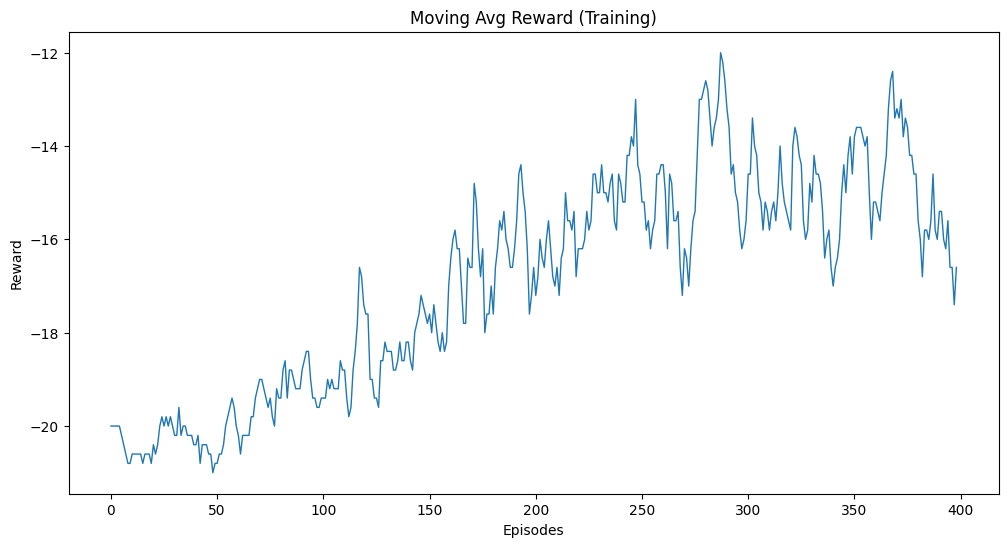

In [48]:
# YOUR CODE HERE

# Show the moving average reward during the training process

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(train_reward, linewidth=1)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

17 - Show the average evaluation score curve as a function of the number of episodes

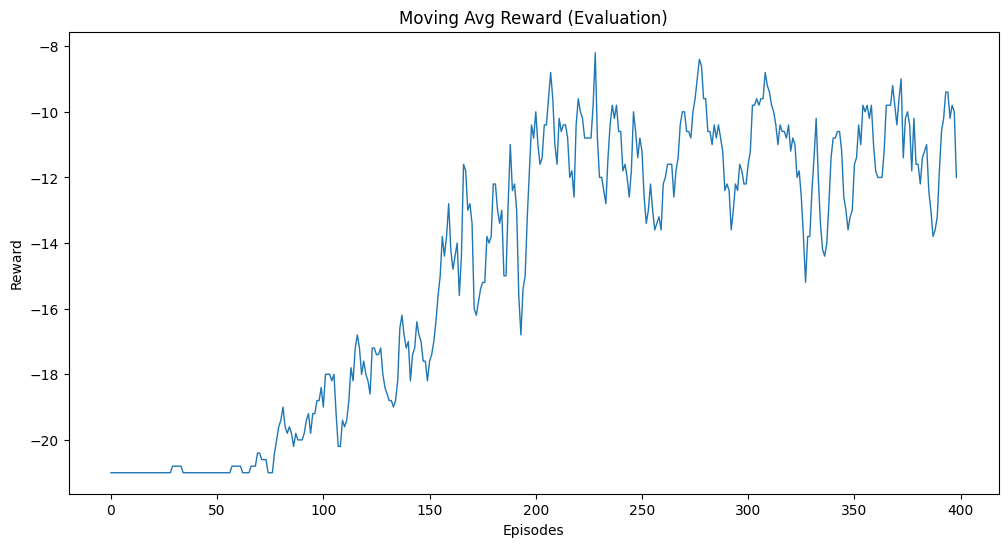

In [45]:
# YOUR CODE HERE

# Show the moving average reward of the evaluation process

plt.figure(figsize=(12,6))

plt.plot(eval_score, linewidth=1)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

18 - Show the best agent playing the game using the greedy policy   

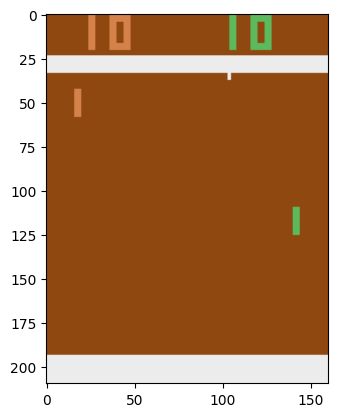

In [26]:
# YOUR CODE HERE

# You can show the policy learned by the agent using the "show_policy" function, as best policy
# you have to load the weights saved on disk.

# create the environment
env = make_atari_env(env_name)

state_shape = env.observation_space.shape
action_size = env.action_space.n

# create the agent from the saved model
path = os.path.join("./", "model_dqn.pth")
agent = Approximator(state_shape, action_size)
agent.load_state_dict(torch.load(path))

show_policy(env, agent, n_episodes=1, max_steps=2000)

19 - The simple DQN learns something, but the task is too complex. We can try to improve the performance applying the modifications, starting from the Prioritized Experience Replay.

In [30]:
# YOUR CODE HERE

# Copy the implementation from the lecture notes, remember to modify in order to take into accont
# the stack of four frames as state

class ReplayMemory():
    def __init__(self, state_shape, memory_size, batch_size):
        self.memory_size = memory_size
        self.batch_size = batch_size

        self.states = np.empty(shape=(memory_size, state_shape[0], state_shape[1], state_shape[2]), dtype=np.float32)
        self.actions = np.empty(shape=(memory_size), dtype=np.int8)
        self.rewards = np.empty(shape=(memory_size), dtype=np.float32)
        self.next_states = np.empty(shape=(memory_size, state_shape[0], state_shape[1], state_shape[2]), dtype=np.float32)
        self.is_failures = np.empty(shape=(memory_size), dtype=np.int8)
        self.priorities = np.empty(shape=(memory_size), dtype=np.float32)
        
        self.n_entries = 0
        self.next_index = 0

        self.alpha = 0.4
        self.beta = 0.4

    def store(self, state, action, reward, next_state, is_failure):
        
        # calculate the priority for the sample using
        # the highest magnitude TD error in the memory
        priority = 1.0
        if self.len() > 0:
            priority = self.priorities[:self.len()].max()

        # insert the sample and its priority into the memory
        self.states[self.next_index] = state
        self.actions[self.next_index] = action
        self.rewards[self.next_index] = reward
        self.next_states[self.next_index] = next_state
        self.is_failures[self.next_index] = is_failure
        self.priorities[self.next_index] = priority
        
        self.n_entries = min(self.n_entries + 1, self.memory_size)
        self.next_index += 1
        self.next_index = self.next_index % self.memory_size

    
    def update(self, idxs, td_errors):
        # takes the array of experiences ids, and new TD error values
        # insert the absolute TD errors into the right place.
        self.priorities[idxs] = np.abs(td_errors)

    def sample(self, batch_size=None):
        batch_size = self.batch_size if batch_size == None else batch_size
        if(batch_size > self.len()): raise Exception("Batch size is greater than the memory size")
      
        # go from priorities to probabilities
        priorities = self.priorities[:self.len()] + 1e-6
        scaled_priorities = priorities ** self.alpha               

        probs = scaled_priorities / np.sum(scaled_priorities)
        
        # calculate the importance-sampling weights using the probabilities
        weights = (self.len() * probs) ** -self.beta
        weights = weights/weights.max()

        # sample experiences in the memory using the probabilities
        idxs = np.random.choice(self.len(), batch_size, replace=False, p=probs)

        weights = weights[idxs]
        states = self.states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        next_states = self.next_states[idxs]
        is_failures = self.is_failures[idxs]

        return idxs, weights, states, actions, rewards, next_states, is_failures

    def len(self):
        return self.n_entries

20 - Add the Double DQN to the algorithm.

In [32]:
# YOUR CODE HERE

# Copy the implementation from the lecture notes, remember to modify in order to take into accont
# the stack of four frames as state

def optimize(memory, online_model, target_model, optimizer, gamma):

    # sample a mini batch of transition from the replay buffer
    idxs, weights, states, actions, rewards, next_states, is_failures = memory.sample()

    weights = torch.from_numpy(np.vstack(weights)).float()
    states = torch.from_numpy(states).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(next_states).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float().float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()
        
    # get the best action for the next state from the online model 
    q_online_next = online_model(next_states).detach()
    argmax_q_online_next = q_online_next.max(1)[1].unsqueeze(1)

    # get the values of that action from the target model
    q_target_next = target_model(next_states).detach()
    max_q_target_next = q_target_next.gather(1, argmax_q_online_next)
    max_q_target_next *= (1 - is_failures)

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # finally, we get the current estimate of Q(s,a), here we query the current "online" network
    q_online_current = online_model(states).gather(1, actions)
    
    # create the errors
    td_errors = target - q_online_current

    # calculate the loss, and optimize the online network
    # now the loss function has TD errors downscaled by the weights
    value_loss = (weights * td_errors).pow(2).mul(0.5).mean()

    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()

    # update the priorities of the replayed batch using the absolute TD errors
    priorities = np.abs(td_errors.detach().numpy())
    memory.update(idxs, priorities.squeeze())

21 - Add the Dueling DQN to the algorithm and see if you can improve the performance of the agent.

In [27]:
# YOUR CODE HERE

# Copy the implementation from the lecture notes, remember to modify in order to take into accont
# the stack of four frames as state

import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_shape, action_size):
        super(Approximator, self).__init__()

        self.conv = torch.nn.Sequential(
                    torch.nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(32, 64, kernel_size=4, stride=2),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(64, 64, kernel_size=3, stride=1),
                    torch.nn.ReLU()
        )

        self.fc = torch.nn.Sequential(
                  torch.nn.Linear(7 * 7 * 64, 512),
                  torch.nn.ReLU(),
        )
 
        self.value_output = torch.nn.Linear(512, 1)
        self.advantage_output = torch.nn.Linear(512, action_size)
        
    def forward(self, state):
        x = self.conv(state)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        a_values = self.advantage_output(x)
        v_values = self.value_output(x)
        q_values = v_values + (a_values - a_values.mean())
        return q_values

    def select_action(self, state):
        state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
        q_values = self(state)
        action = q_values.max(1)[1].data[0]
        return action

22 - Re-run the algorithm with alle the modifications and compare the results.

In [33]:
# YOUR CODE HERE

# Use the sane code already used for the experiment with DQN, with the same hyperparameters. Just 
# change the target_update_steps equal to 1.

max_episodes = 300
max_time = 60*60*7
max_score = 20

episodes_window = 5

gamma = 0.99
learning_rate = 0.0001

epsilon_max = 1
epsilon_min = 0.3
decay_episodes = int(0.5 * max_episodes)

replay_memory_size = 100000
starting_memory_size = 10000
batch_size = 64 

online_optimize_steps = 1
target_update_steps = 1

seed = 42

filename = 'model_vpg.pth'
agent, score, result = dqn(env_name, seed, filename,
                           replay_memory_size, starting_memory_size, batch_size,
                           online_optimize_steps, target_update_steps,
                           epsilon_max, epsilon_min, decay_episodes,
                           learning_rate, gamma, 
                           max_episodes, max_time, max_score, episodes_window)

episode 0129, steps 159248, average score -14.2, average return -15.0  --> reached_max_time 


23 - Extract values from the results

In [34]:
# YOUR CODE HERE

# Simply extract steps, train_reward, eval_score and training_time from the 
# results produced by the algorithm

steps, train_reward, eval_score, training_time  = result.T

24 - Show the average reward curve as a function of the number of episodes

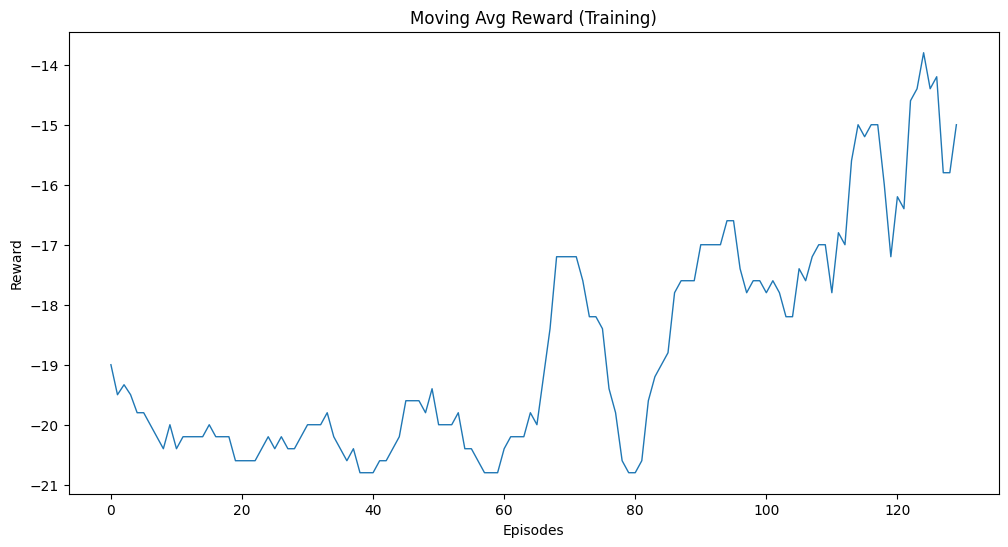

In [35]:
# YOUR CODE HERE

# Show the moving average reward during the training process

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(train_reward, linewidth=1)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

25 - Show the average evaluation score curve as a function of the number of episodes

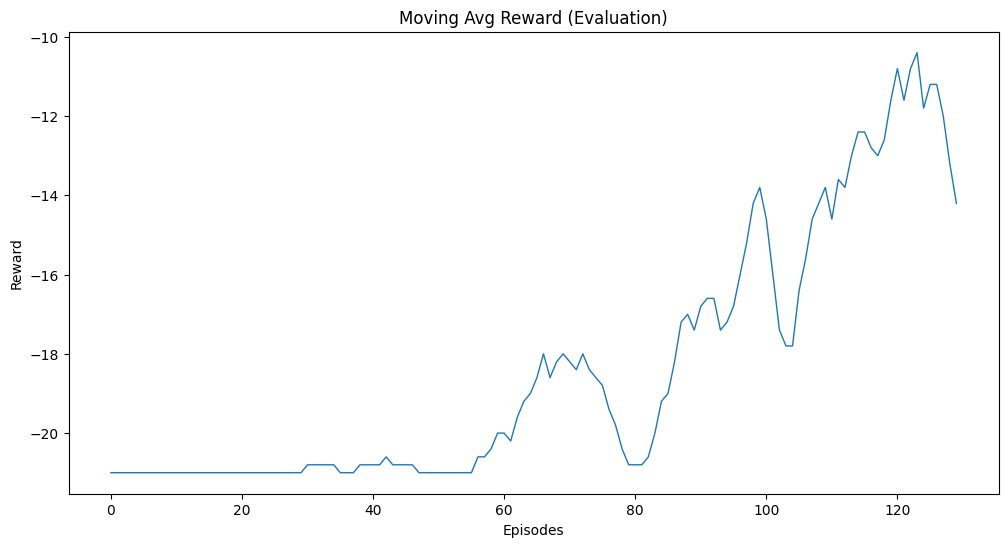

In [36]:
# YOUR CODE HERE

# Show the moving average reward of the evaluation process

plt.figure(figsize=(12,6))

plt.plot(eval_score, linewidth=1)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

26 - Show the best agent playing the game using the greedy policy  

In [9]:
# YOUR CODE HERE

import os

# You can show the policy learned by the agent using the "show_policy" function, as best policy
# you have to load the weights saved on disk.

# create the environment
env = make_atari_env(env_name)

state_shape = env.observation_space.shape
action_size = env.action_space.n

# create the agent from the saved model
path = os.path.join("./", "model_vpg.pth")
agent = Approximator(state_shape, action_size)
agent.load_state_dict(torch.load(path))

show_policy(env, agent, n_episodes=1, max_steps=2000)

NameError: name 'Approximator' is not defined